In [1]:
## Use the setup.py file to output directories. 
import sys
sys.path.append('/global/homes/z/zzhang13/BaryonPasting/CorrelatedStructures/multiDark/')

from setup import *
toolsdir = tools_dir()
repodir = repo_dir()
chainsdir = chains_dir()
datadir = data_dir()
plotdir = plots_dir()

sys.path.append(toolsdir)
sys.path.append(repodir)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import scipy.stats as stats
import matplotlib.cm as cm
#from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_selection import f_regression
from statsmodels.stats.anova import anova_lm
from statsmodels.compat import lzip
#sns.set()
#pd.set_option('display.notebook_repr_html', True)
#pd.set_option('display.precision', 2)
#%matplotlib notebook
#plt.rcParams['figure.figsize'] = 10, 10
from scipy.stats import norm
from scipy import stats

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import sys
sys.path.append('/global/u1/z/zzhang13')

from kllr.kllr.regression_model import *
from kllr.kllr.regression_plotting import *
from kllr.kllr.calc_cov_KLLR import *

nBootstrap=20

In [5]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# function to check VIF
def checking_vif(train):
    vif = pd.DataFrame()
    vif["feature"] = train.columns

    # calculating VIF for each feature
    vif["VIF"] = [
        variance_inflation_factor(train.values, i) for i in range(len(train.columns))
    ]
    return vif

## Collecting the data

For all redshifts and masses

In [6]:
with open(datadir + 'MDPL2_DS_R200c_SAGE_Ngal_allM_allz.p', 'rb') as f:
    matched_halo_df = pickle.load(f)

In [7]:
matched_halo_df['lnl'] = np.log10(matched_halo_df['Ngal_R200c'])

In [8]:
matched_halo_df.columns

Index(['id', 'Xoff', 'scale', 'CtreesHaloID', 'pid', 'mvir', 'rvir', 'rs', 'x',
       'y', 'z', 'Mmvir_all', 'M200b', 'M200c', 'M500c', 'T/|U|',
       'Halfmass_Scale', 'Acc_Rate_Inst', 'Acc_Rate_100Myr', 'Acc_Rate_1*Tdyn',
       'Acc_Rate_2*Tdyn', 'Acc_Rate_Mpeak', 'c_vir', 'R200c', 'R500c',
       'redshift', 'Ngal_Dsep_1', 'Ngal_Rvir', 'Ngal_R200c', 'Ngal_R500c',
       'sigma', 'r_range', 'delta_sigma', 'lnl'],
      dtype='object')

In [9]:
mass_bin_edges = [5e13, 1e14, 2e14, 5e14, 1e15]
mass_bins = [[mass_bin_edges[i],mass_bin_edges[i+1]] for i in range(len(mass_bin_edges)-1)]

a_bins = [1, 0.6712, 0.4922]
column_name ='Acc_Rate_2*Tdyn'

In [10]:
## Testing the file properties. 
r_bins_log_norm = np.linspace(-1,1,21)
r_bins_lin_norm = 10**r_bins_log_norm
r_cent_log_norm= (r_bins_log_norm[1:] + r_bins_log_norm[:-1])/2
r_cent_lin_norm = 10**r_cent_log_norm

## Correlation of parameters

In [11]:
display(matched_halo_df[['mvir','M200b','T/|U|', 'Halfmass_Scale',
       'Acc_Rate_Inst', 'Acc_Rate_100Myr', 'Acc_Rate_1*Tdyn',
       'Acc_Rate_2*Tdyn', 'Acc_Rate_Mpeak', 'c_vir','Xoff']].corr())

,mvir,M200b,T/|U|,Halfmass_Scale,Acc_Rate_Inst,Acc_Rate_100Myr,Acc_Rate_1*Tdyn,Acc_Rate_2*Tdyn,Acc_Rate_Mpeak,c_vir,Xoff
mvir,1.000000,0.996814,0.034243,0.407490,0.338197,0.338197,0.529013,0.670650,0.691656,-0.019834,0.314235
M200b,0.996814,1.000000,0.015476,0.422950,0.322744,0.322744,0.492807,0.632935,0.656648,-0.012628,0.296177
T/|U|,0.034243,0.015476,1.000000,0.056472,0.443808,0.443808,0.515368,0.377279,0.348402,-0.332531,0.628834
Halfmass_Scale,0.407490,0.422950,0.056472,1.000000,0.043399,0.043399,0.159429,0.161179,0.125184,-0.017502,0.254800
Acc_Rate_Inst,0.338197,0.322744,0.443808,0.043399,1.000000,1.000000,0.717195,0.571530,0.557310,-0.262031,0.482098
Acc_Rate_100Myr,0.338197,0.322744,0.443808,0.043399,1.000000,1.000000,0.717195,0.571530,0.557310,-0.262031,0.482098
Acc_Rate_1*Tdyn,0.529013,0.492807,0.515368,0.159429,0.717195,0.717195,1.000000,0.869208,0.822113,-0.172100,0.561522
Acc_Rate_2*Tdyn,0.670650,0.632935,0.377279,0.161179,0.571530,0.571530,0.869208,1.000000,0.966471,-0.291226,0.561393
Acc_Rate_Mpeak,0.691656,0.656648,0.348402,0.125184,0.557310,0.557310,0.822113,0.966471,1.000000,-0.278141,0.533612
c_vir,-0.019834,-0.012628,-0.332531,-0.017502,-0.262031,-0.262031,-0.172100,-0.291226,-0.278141,1.000000,-0.502686


M5e+13-1e+14, z=0.00
T/|U|
c_vir
Halfmass_Scale
Acc_Rate_2*Tdyn
Xoff


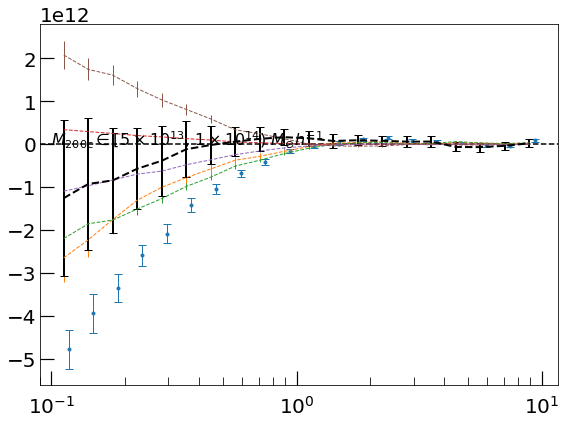

In [30]:
from scipy import stats
nBootstrap = 10
X_params = ['T/|U|', 'c_vir', 'Halfmass_Scale', 'Acc_Rate_2*Tdyn', 'Xoff']
#X_params = ['c_vir', 'Acc_Rate_2*Tdyn']

plt.figure(figsize=(8,6), tight_layout=True)

for i, cur_mass_bin in enumerate(mass_bins):
    for j, cur_a_bin in enumerate(a_bins):     
        mass_min = cur_mass_bin[0]; mass_max = cur_mass_bin[1]
        print('M{:.2g}-{:.2g}, z={:.2f}'.format(mass_min, mass_max, 1/cur_a_bin-1))
        mask = (matched_halo_df.mvir >= mass_min) & (matched_halo_df.mvir < mass_max) & (matched_halo_df.scale == cur_a_bin) 
        cur_df = matched_halo_df[mask]
        
        if len(cur_df) < 100: 
            axs[i,j].set_visible(False)
            continue
            
        ##Compute Cov. and error total
        xline, output = calc_cov_KLLR(np.log10(np.array(cur_df['M200c'],dtype=float)) , np.vstack(cur_df['delta_sigma']), \
                                       np.log10(np.array(cur_df['Ngal_R200c'],dtype=float)), nBootstrap=nBootstrap)
        cov_ds_ngal_kllr = output['covariance']
        cov_mean_kllr = np.mean(cov_ds_ngal_kllr, axis=0)
        cov_err_kllr = np.std(cov_ds_ngal_kllr, axis=0)
        plt.errorbar(1.05*r_cent_lin_norm, cov_mean_kllr, yerr=cov_err_kllr, label='Total', linestyle='none', marker='o', markersize=3, capsize=4, elinewidth=1)

        ##Apply linear regression
        X = cur_df[X_params]
        X = sm.add_constant(X)
        y = np.log10(np.array(cur_df['Ngal_R200c'],dtype=float))
        mreg = sm.OLS(y, X).fit()
        
        ###Diagnostic tests.
        #display(mreg.summary())
        #print("Partial F statistic:", X.columns)
        #(F, pval) = f_regression(X, y)
        #display(F, pval)
        #print(checking_vif(X))
        #residuals = mreg.resid
        #print(stats.shapiro(residuals)) ## Apply the Shapiro-Wilk test
        
        
        cov_remain_kllr = np.copy(cov_mean_kllr)
        cov_err_remain = np.copy(cov_err_kllr)
        for X_param in iter(X_params):
            print(X_param)
            ### Compute Cov and errors of Cov. 
            coeff_param = mreg.params[X_param]
            xline, cov_corr = calc_cov_KLLR(np.log10(np.array(cur_df['M200c'],dtype=float)), np.vstack(cur_df['delta_sigma']), \
                                            np.array(cur_df[X_param],dtype=float), nBootstrap=nBootstrap)

            cov_param = np.mean(cov_corr['covariance'], axis=0)
            cov_err_param = np.std(cov_corr['covariance'], axis=0)
            plt.errorbar(r_cent_lin_norm, coeff_param*cov_param, yerr=coeff_param*cov_err_param, label=X_param, linestyle='dashed', linewidth = 1)

            ###Compute the remaining Cov after removing parameters
            cov_remain_kllr -= coeff_param*cov_param
            cov_err_remain += np.abs(coeff_param)*cov_err_param
        plt.errorbar(r_cent_lin_norm, cov_remain_kllr, yerr=cov_err_remain, label='Remaining', linestyle='dashed', linewidth=2, color='black', capsize=4, elinewidth=2)
        plt.text(0.1, 0.95,  r'$M_{\rm 200c} \in $'+r'[${0:s}$, '.format(as_si(mass_min,0)) + r'${0:s}$)'.format(as_si(mass_max,0)) + ' $M_{\odot}h^{-1}$', \
                                 fontsize = 16)
        
        
        ##Plotting configu
        plt.axhline(0,linestyle='dashed', color='black')
        plt.xscale('log'); #plt.yscale('log')
        
        break
    break

#plt.legend(loc='lower right', fontsize=14)
#plt.savefig(plot_dir+'cov_time_formation_m5e13_1e14_z0p00_.png')
plt.show()

## Plotting the Covariance for all

In [12]:
def as_si(x, ndp):
    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    return r'{m:s}\times 10^{{{e:d}}}'.format(m=m, e=int(e))

M5e+13-1e+14, z=0.00
M5e+13-1e+14, z=0.49
M5e+13-1e+14, z=1.03
M1e+14-2e+14, z=0.00
M1e+14-2e+14, z=0.49
M1e+14-2e+14, z=1.03
M2e+14-5e+14, z=0.00
M2e+14-5e+14, z=0.49
M2e+14-5e+14, z=1.03
M5e+14-1e+15, z=0.00
M5e+14-1e+15, z=0.49
M5e+14-1e+15, z=1.03


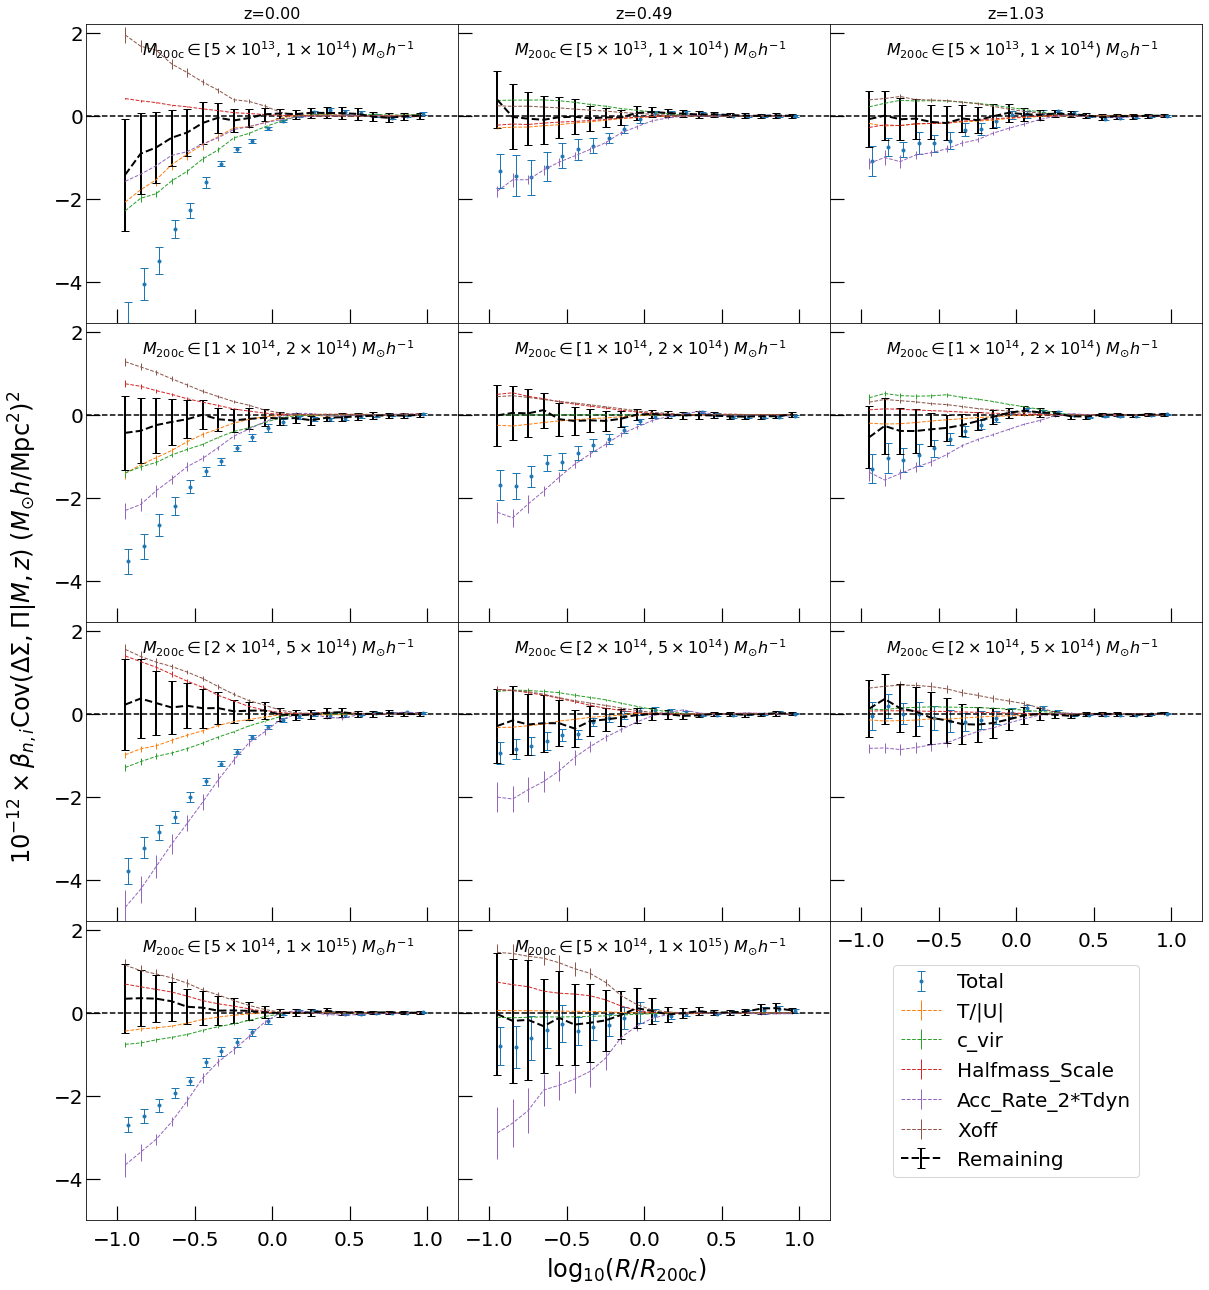

In [13]:
from scipy import stats
nBootstrap = 10
fig, axs = plt.subplots(4, 3, figsize=(20,22), sharex=False, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)
fontsize=24
legendsize = 20

X_params = ['T/|U|', 'c_vir', 'Halfmass_Scale', 'Acc_Rate_2*Tdyn', 'Xoff']

for i, cur_mass_bin in enumerate(mass_bins):
    for j, cur_a_bin in enumerate(a_bins):     
        mass_min = cur_mass_bin[0]; mass_max = cur_mass_bin[1]
        print('M{:.2g}-{:.2g}, z={:.2f}'.format(mass_min, mass_max, 1/cur_a_bin-1))
        
        mask = (matched_halo_df.M200c >= mass_min) & (matched_halo_df.M200c < mass_max) & (matched_halo_df.scale == cur_a_bin) 
        cur_df = matched_halo_df[mask]
        
        if len(cur_df) < 100: 
            axs[i,j].set_visible(False)
            continue
            
            
        ##Computing the Covariance##
        
        ##Compute Cov. and error total
        xline, output = calc_cov_KLLR(np.log10(np.array(cur_df['M200c'],dtype=float)) , np.vstack(cur_df['delta_sigma']), \
                                       np.log10(np.array(cur_df['Ngal_R200c'],dtype=float)), nBootstrap=nBootstrap)
        cov_ds_ngal_kllr = output['covariance']
        cov_mean_kllr = np.mean(cov_ds_ngal_kllr, axis=0)/1e12
        cov_err_kllr = np.std(cov_ds_ngal_kllr, axis=0)/1e12
        axs[i,j].errorbar(np.log10(1.05*r_cent_lin_norm), cov_mean_kllr, yerr=cov_err_kllr, label='Total', linestyle='none', marker='o', markersize=3, capsize=4, elinewidth=1)

        ##Apply linear regression
        X = cur_df[X_params]
        X = sm.add_constant(X)
        y = np.log10(np.array(cur_df['Ngal_R200c'],dtype=float))
        mreg = sm.OLS(y, X).fit()
        
        ###Diagnostic tests.
        #display(mreg.summary())
        #print("Partial F statistic:", X.columns)
        #(F, pval) = f_regression(X, y)
        #display(F, pval)
        #print(checking_vif(X))
        #residuals = mreg.resid
        #print(stats.shapiro(residuals)) ## Apply the Shapiro-Wilk test
        
        
        cov_remain_kllr = np.copy(cov_mean_kllr)
        cov_err_remain = np.copy(cov_err_kllr)
        for X_param in iter(X_params):
            #print(X_param)
            ### Compute Cov and errors of Cov. 
            coeff_param = mreg.params[X_param]
            xline, cov_corr = calc_cov_KLLR(np.log10(np.array(cur_df['M200c'],dtype=float)), np.vstack(cur_df['delta_sigma']), \
                                            np.array(cur_df[X_param],dtype=float), nBootstrap=nBootstrap)

            cov_param = np.mean(cov_corr['covariance'], axis=0)/1e12
            cov_err_param = np.std(cov_corr['covariance'], axis=0)/1e12
            axs[i,j].errorbar(np.log10(r_cent_lin_norm), coeff_param*cov_param, yerr=coeff_param*cov_err_param, label=X_param, linestyle='dashed', linewidth = 1)


            ###Compute the remaining Cov after removing parameters
            cov_remain_kllr -= coeff_param*cov_param
            cov_err_remain += np.abs(coeff_param)*cov_err_param
        axs[i,j].errorbar(np.log10(r_cent_lin_norm), cov_remain_kllr, yerr=cov_err_remain, label='Remaining', linestyle='dashed', linewidth=2, color='black', capsize=4, elinewidth=2)
        
        
        ##Plotting configu
        axs[i,j].axhline(0,linestyle='dashed', color='black')
        #axs[i,j].set_xscale('log'); #plt.yscale('log')
                    
        if i == 0: axs[i,j].set_title('z={:.2f}'.format(1/cur_a_bin-1), fontsize=16)
        
        ### Mass bin
        axs[i,j].text(0.15, 0.9,  r'$M_{\rm 200c} \in $'+r'[${0:s}$, '.format(as_si(mass_min,0)) + r'${0:s}$)'.format(as_si(mass_max,0)) + ' $M_{\odot}h^{-1}$', \
                                 fontsize = 16, transform=axs[i,j].transAxes)
        
        
        #if j == 2: axs[i,j].text(1, 0.05,  r'$M_{\rm 200c} \in $'+r'[${0:s}$, '.format(as_si(mass_min,0)) + r'${0:s}$)'.format(as_si(mass_max,0)) + ' $M_{\odot}h^{-1}$', \
        #              rotation = -90, fontsize = 16, transform=axs[i,j].transAxes)
        #if (i == 2) & (j == 1): axs[i,j].text(2, 0.05,  r'$M_{\rm 200c} \in $'+r'[${0:s}$, '.format(as_si(mass_min,0)) + r'${0:s}$)'.format(as_si(mass_max,0)) + ' $M_{\odot}h^{-1}$', \
        #              rotation = -90, fontsize = 16, transform=axs[i,j].transAxes)
        #if (i == 3) & (j == 0): axs[i,j].text(3, 0.05,  r'$M_{\rm 200c} \in $'+r'[${0:s}$, '.format(as_si(mass_min,0)) + r'${0:s}$)'.format(as_si(mass_max,0)) + ' $M_{\odot}h^{-1}$', \
        #              rotation = -90, fontsize = 16, transform=axs[i,j].transAxes) 
        
        axs[i,j].set_ylim([-5,2.2])
        axs[i,j].set_xlim([-1.2,1.2])
            

axs[3,0].legend(loc='center', bbox_to_anchor=(2.5,0.5), fontsize=legendsize)
fig.text(0.5, 0.09, r'$\log_{10}(R/R_{\rm 200c})$', fontsize=fontsize, ha='center')
fig.text(0.07, 0.5, r'$10^{-12} \times \beta_{n,i} \mathrm{Cov}$' + r'$(\Delta\Sigma, \Pi | M, z)$ ($M_{\odot}h$/Mpc$^2$)$^2$', fontsize=fontsize, va='center', rotation='vertical')

plt.savefig(plotdir+'cov_R200c_split_Xparams.pdf', bbox_inches='tight')
plt.show()

## Testing the model on subset of data
Using z=0.00, one single mass bin

* Determine using F-regression which variables to use.
* Check for residuals
* Homodescedity
* Normal errors
* Multi-collinearity

In [25]:
a_bins = [1, 0.6712, 0.4922]

In [37]:
mask = (matched_halo_df.mvir >= 1e14) & (matched_halo_df.mvir < 2e14) & (matched_halo_df.scale == 1) 
cur_df = matched_halo_df[mask]

In [38]:
cur_df.c_vir

14      4.132651
15      5.114444
16      7.612013
17      3.514530
18      7.178709
          ...   
1200    2.934424
1201    5.090178
1202    2.309766
1203    4.432682
1204    8.732649
Name: c_vir, Length: 507, dtype: float64

In [39]:
Mvir = np.log10(np.copy(cur_df['mvir']))
richness = np.copy(cur_df['Ngal_R200c'])

In [40]:
cur_df['logM'] = np.log10(Mvir)
cur_df['lnl'] = np.log10(richness)

##Inclusive of all parameters
X_params = ['T/|U|', 'c_vir', 'Halfmass_Scale', 'Acc_Rate_2*Tdyn', 'Xoff']
#X_params = ['Halfmass_Scale', 'Acc_Rate_2*Tdyn']
X = cur_df[X_params]
#X = cur_df[['logM', 'Acc_Rate_2*Tdyn']]

#DS_inner = np.copy(cur_df['delta_sigma'])
#DS_inner = np.vstack(DS_inner)
#DS_inner = DS_inner[:,0]
y = np.log10(richness)


In [41]:
X = sm.add_constant(X)
mreg = sm.OLS(y, X).fit()
display(mreg.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.384
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     62.34
Date:                Thu, 26 Jan 2023   Prob (F-statistic):           1.69e-50
Time:                        11:42:59   Log-Likelihood:                 361.87
No. Observations:                 507   AIC:                            -711.7
Df Residuals:                     501   BIC:                            -686.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.1266      0.087     12.984      0.000       0.956       1.297
T/|U|               0.6815      0.149      4.568      0.000       0.388       0.975
c_vir              -0.0132      0.004     -3.274      0.001      -0.021      -0.005
Halfmass_Scale     -0.0129      0.079     -0.163      0.870      -0.168       0.142
Acc_Rate_2*Tdyn  9.692e-06   9.97e-07      9.717      0.000    7.73e-06    1.17e-05
Xoff               -0.0009      0.000     -5.012      0.000      -0.001      -0.001
==============================================================================
Omnibus:                       10.960   Durbin-Watson:                   1.522
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.129
Skew:                          -0.360   Prob(JB):                      0.00383
Kurtosis:                       3.096   Cond. No.                     4.55e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.55e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Apply a F-regression test to see which variables to use and which to omit

Highest one is 'Acc_Rate_2*Tdyn' and 'logM'

In [331]:
print(X.columns)
(F, pval) = f_regression(X, y)
display(F, pval)

Index(['const', 'Halfmass_Scale', 'Acc_Rate_2*Tdyn'], dtype='object')


array([         nan,  62.3922991 , 316.15032861])

array([           nan, 1.81413641e-14, 3.99774914e-55])

### Test for homodescitiy

If p>0.05 keep the null hypothesis for homodescity

In [332]:
## Test for homodes
name = ['Lagrange multiplier statistic', 'p-value', 
        'f-value', 'f p-value']
test = sms.het_breuschpagan(mreg.resid, mreg.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 11.012898934992855),
 ('p-value', 0.004060498752392812),
 ('f-value', 5.596682160705698),
 ('f p-value', 0.003947831294861755)]

### Check for multi-collinearity

VIF > 5 include:
* Acc_Rate parameters. Retain only 1

In [333]:
print(checking_vif(X))

           feature        VIF
0            const  92.263964
1   Halfmass_Scale   2.017006
2  Acc_Rate_2*Tdyn   2.017006


### Check for Gaussian residuals 

In [334]:
residuals = mreg.resid

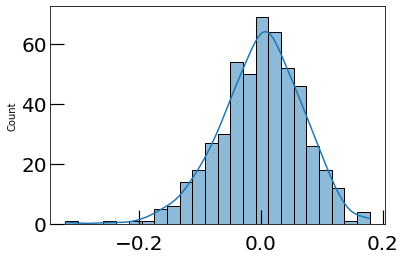

In [335]:
# Plot histogram of residuals
sns.histplot(residuals, kde=True)
plt.show()

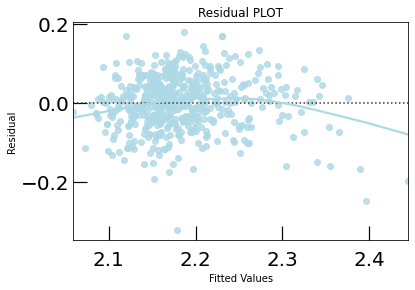

In [336]:
fitted = mreg.fittedvalues

# sns.set_style("whitegrid")
sns.residplot(x = fitted, y = residuals, color="lightblue", lowess=True)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Residual PLOT")
plt.show()

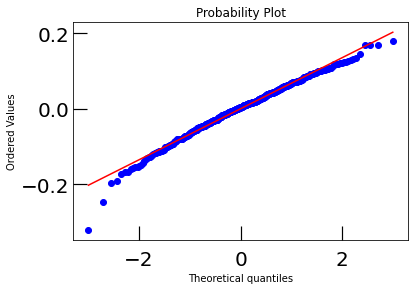

In [337]:
# Plot q-q plot of residuals
import pylab
import scipy.stats as stats

stats.probplot(residuals, dist="norm", plot=pylab)
plt.show()

In [338]:
## Apply the KS Test
from scipy.stats import kstest, norm
ks_statistic, p_value = kstest(residuals, 'norm')
print(ks_statistic, p_value)

0.43637764852644245 3.9485338999690644e-87


In [339]:
## Apply the Shapiro-Wilk test
from scipy.stats import norm
from scipy import stats
stats.shapiro(residuals)

ShapiroResult(statistic=0.9874087572097778, pvalue=0.0002602220047265291)

### Mean of residuals =0 

In [340]:
print(np.mean(residuals))
print(np.std(residuals))

2.2447284919735467e-11
0.06785534984154334


### Reduce coefficients using M and highest F-statistic only


In [248]:
X_reduce = cur_df[['Acc_Rate_2*Tdyn']]

In [249]:
X_reduce = sm.add_constant(X_reduce)
mreg2 = sm.OLS(y, X_reduce).fit()
display(mreg2.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     160.2
Date:                Mon, 12 Sep 2022   Prob (F-statistic):           5.18e-30
Time:                        17:56:42   Log-Likelihood:                 295.02
No. Observations:                 320   AIC:                            -586.0
Df Residuals:                     318   BIC:                            -578.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.5449      0.014    106.950      0.000       1.516       1.573
Acc_Rate_2*Tdyn  8.892e-06   7.03e-07     12.657      0.000    7.51e-06    1.03e-05
==============================================================================
Omnibus:                        0.857   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.652   Jarque-Bera (JB):                0.750
Skew:                          -0.118   Prob(JB):                        0.687
Kurtosis:                       3.028   Cond. No.                     5.50e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.5e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [250]:
print(checking_vif(X_reduce))

           feature       VIF
0            const  7.163278
1  Acc_Rate_2*Tdyn  1.000000


### Check for Gaussian residuals

In [251]:
residuals = mreg2.resid

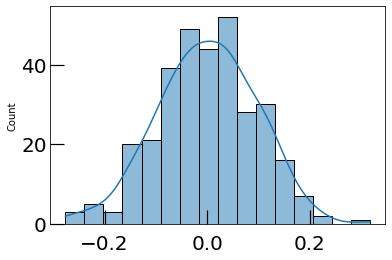

In [252]:
# Plot histogram of residuals
sns.histplot(residuals, kde=True)
plt.show()

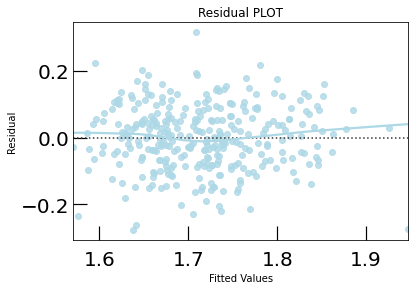

In [253]:
fitted = mreg2.fittedvalues

# sns.set_style("whitegrid")
sns.residplot(x = fitted, y = residuals, color="lightblue", lowess=True)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Residual PLOT")
plt.show()

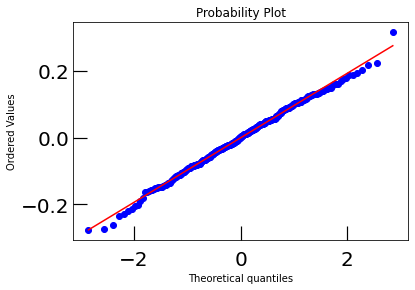

In [254]:
# Plot q-q plot of residuals
import pylab
import scipy.stats as stats

stats.probplot(residuals, dist="norm", plot=pylab)
plt.show()

In [255]:
## Apply the KS Test
from scipy.stats import kstest, norm
ks_statistic, p_value = kstest(residuals, 'norm')
print(ks_statistic, p_value)

0.41059276515894283 2.6218726615983446e-49


## Compute Covariance

Run across mass and redshift bins for the full linear regression model. 

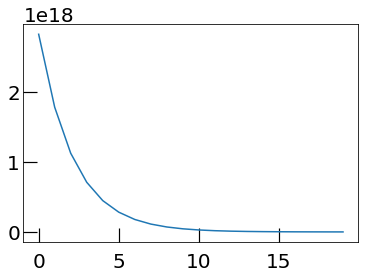

In [347]:
plt.plot(np.mean(np.vstack(cur_df.delta_sigma), axis=0))
plt.show()

In [348]:
display(cur_df[['mvir','M200b','T/|U|', 'Halfmass_Scale',
       'Acc_Rate_Inst', 'Acc_Rate_100Myr', 'Acc_Rate_1*Tdyn',
       'Acc_Rate_2*Tdyn', 'Acc_Rate_Mpeak', 'c_vir']].corr())



,mvir,T/|U|,Halfmass_Scale,Acc_Rate_Inst,Acc_Rate_100Myr,Acc_Rate_1*Tdyn,Acc_Rate_2*Tdyn,Acc_Rate_Mpeak,c_vir
mvir,1.000000,0.053001,0.047163,0.253403,0.253403,0.372796,0.577193,0.615652,-0.048180
T/|U|,0.053001,1.000000,0.638348,0.596490,0.596490,0.722642,0.459072,0.422157,-0.156246
Halfmass_Scale,0.047163,0.638348,1.000000,0.387201,0.387201,0.691031,0.710081,0.692476,-0.321483
Acc_Rate_Inst,0.253403,0.596490,0.387201,1.000000,1.000000,0.647544,0.407901,0.376055,-0.314551
Acc_Rate_100Myr,0.253403,0.596490,0.387201,1.000000,1.000000,0.647544,0.407901,0.376055,-0.314551
Acc_Rate_1*Tdyn,0.372796,0.722642,0.691031,0.647544,0.647544,1.000000,0.743551,0.678532,-0.144025
Acc_Rate_2*Tdyn,0.577193,0.459072,0.710081,0.407901,0.407901,0.743551,1.000000,0.977836,-0.345438
Acc_Rate_Mpeak,0.615652,0.422157,0.692476,0.376055,0.376055,0.678532,0.977836,1.000000,-0.348283
c_vir,-0.048180,-0.156246,-0.321483,-0.314551,-0.314551,-0.144025,-0.345438,-0.348283,1.000000


In [349]:
nBootstrap = 10
xline, output = calc_cov_KLLR(np.log10(np.array(cur_df['mvir'],dtype=float)) , np.vstack(cur_df['delta_sigma']), \
                                       np.log10(np.array(cur_df['Ngal'],dtype=float)), nBootstrap=nBootstrap)
cov_ds_ngal_kllr = output['covariance']
cov_mean_kllr = np.mean(cov_ds_ngal_kllr, axis=0)
cov_err_kllr = np.std(cov_ds_ngal_kllr, axis=0)

xline, output = calc_cov_noKLLR(np.vstack(cur_df['delta_sigma']), np.log10(np.array(cur_df['Ngal'],dtype=float)), nBootstrap=nBootstrap)

cov_ds_ngal_simple = output['covariance']
cov_mean_simple = np.mean(cov_ds_ngal_simple, axis=0)
cov_err_simple = np.std(cov_ds_ngal_simple, axis=0)

100%|██████████| 10/10 [00:00<00:00, 562.30it/s]


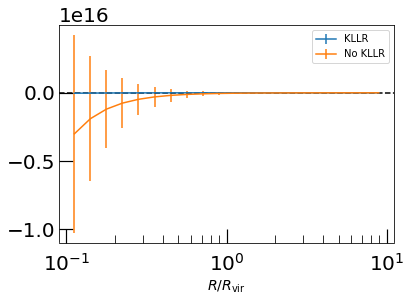

In [350]:
plt.errorbar(r_cent_lin_norm, cov_mean_kllr, yerr = cov_err_kllr, label = 'KLLR')
plt.errorbar(r_cent_lin_norm, cov_mean_simple, yerr = cov_err_simple, label='No KLLR')
plt.axhline(0,linestyle='dashed', color='black')
plt.xscale('log'); #plt.yscale('log')
plt.xlabel(r'$R/R_{\rm vir}$', fontsize=14)
plt.legend()
plt.show()

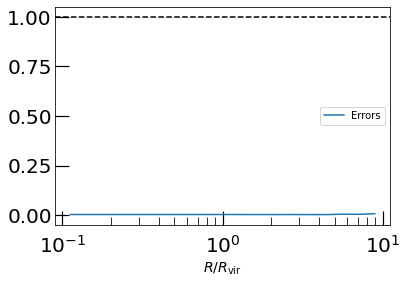

In [351]:
plt.plot(r_cent_lin_norm, cov_err_kllr/cov_err_simple, label='Errors')
plt.axhline(1,linestyle='dashed', color='black')
plt.xscale('log'); #plt.yscale('log')
plt.xlabel(r'$R/R_{\rm vir}$', fontsize=14)
plt.legend()
plt.show()

### Bin by mass

In [352]:
nBootstrap = 10

## Need to build the covariance of the other time formation parameter terms
coeff_halfmass_scale = mreg.params['Halfmass_Scale']	
coeff_T_U = mreg.params['T/|U|']
coeff_c_vir = mreg.params['c_vir']
coeff_Acc_Rate_2Tdyn = mreg.params['Acc_Rate_2*Tdyn']

xline, cov_corr_halfmass_scale = calc_cov_noKLLR(np.vstack(cur_df['delta_sigma']), np.array(cur_df['Halfmass_Scale'],dtype=float), nBootstrap=nBootstrap)
xline, cov_corr_T_U = calc_cov_noKLLR(np.vstack(cur_df['delta_sigma']), np.array(cur_df['T/|U|'],dtype=float), nBootstrap=nBootstrap)
xline, cov_corr_c_vir = calc_cov_noKLLR(np.vstack(cur_df['delta_sigma']), np.array(cur_df['c_vir'],dtype=float), nBootstrap=nBootstrap)
xline, cov_corr_Acc_Rate_Mpeak = calc_cov_noKLLR(np.vstack(cur_df['delta_sigma']), np.array(cur_df['Acc_Rate_2*Tdyn'],dtype=float), nBootstrap=nBootstrap)


KeyError: 'T/|U|'

In [265]:
cov_halfmass_scale = np.mean(cov_corr_halfmass_scale['covariance'], axis=0)
cov_T_U = np.mean(cov_corr_T_U['covariance'], axis=0)
cov_c_vir = np.mean(cov_corr_c_vir['covariance'], axis=0)
cov_Acc_Rate_2Tdyn = np.mean(cov_corr_Acc_Rate_Mpeak['covariance'], axis=0)

['T/|U|', 'c_vir', 'Halfmass_Scale', 'Acc_Rate_2*Tdyn']
T/|U|


100%|██████████| 10/10 [00:02<00:00,  4.81it/s]


c_vir


100%|██████████| 10/10 [00:01<00:00,  5.01it/s]


Halfmass_Scale


100%|██████████| 10/10 [00:01<00:00,  5.32it/s]


Acc_Rate_2*Tdyn


100%|██████████| 10/10 [00:02<00:00,  4.94it/s]


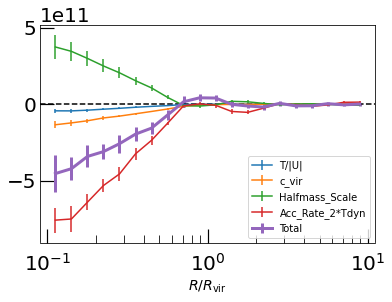

In [272]:
### Iterate through X
print(X_params)
for X_param in iter(X_params):
    print(X_param)
    coeff_param = mreg.params[X_param]
    #xline, cov_corr = calc_cov_noKLLR(np.vstack(cur_df['delta_sigma']), np.array(cur_df[X_param],dtype=float), nBootstrap=nBootstrap)
    xline, cov_corr = calc_cov_KLLR(np.log10(np.array(cur_df['mvir'],dtype=float)), np.vstack(cur_df['delta_sigma']), \
                                    np.array(cur_df[X_param],dtype=float), nBootstrap=nBootstrap)
    
    cov_param = np.mean(cov_corr['covariance'], axis=0)
    cov_err_param = np.std(cov_corr['covariance'], axis=0)
    plt.errorbar(r_cent_lin_norm, coeff_param*cov_param, yerr=coeff_param*cov_err_param, label=X_param)

plt.errorbar(r_cent_lin_norm, cov_mean_kllr, yerr = cov_err_kllr, linewidth=3, label='Total')
plt.axhline(0,linestyle='dashed', color='black')
plt.xscale('log'); #plt.yscale('log')
plt.xlabel(r'$R/R_{\rm vir}$', fontsize=14)
plt.legend()
plt.show()

100%|██████████| 10/10 [00:02<00:00,  4.43it/s]


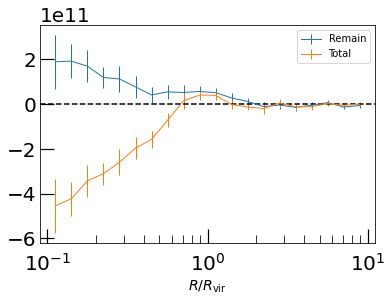

In [267]:
### Iterate through X
cov_remain_kllr = np.copy(cov_mean_kllr)
for X_param in iter(X_params):
    coeff_param = mreg.params[X_param]
    #xline, cov_corr = calc_cov_noKLLR(np.vstack(cur_df['delta_sigma']), np.array(cur_df[X_param],dtype=float), nBootstrap=nBootstrap)
    xline, cov_corr = calc_cov_KLLR(np.log10(np.array(cur_df['mvir'],dtype=float)), np.vstack(cur_df['delta_sigma']), \
                                    np.array(cur_df[X_param],dtype=float), nBootstrap=nBootstrap)
    
    cov_param = np.mean(cov_corr['covariance'], axis=0)
    cov_remain_kllr -= coeff_param*cov_param

plt.errorbar(r_cent_lin_norm, cov_remain_kllr, yerr = cov_err_kllr, linewidth=1, label='Remain')
plt.errorbar(r_cent_lin_norm, cov_mean_kllr, yerr = cov_err_kllr, linewidth=1, label='Total')
plt.axhline(0,linestyle='dashed', color='black')
plt.xscale('log'); 
plt.xlabel(r'$R/R_{\rm vir}$', fontsize=14)
plt.legend()
plt.show()

In [268]:
## Testing the file properties. 
r_bins_log_norm = np.linspace(-1,1,21)
r_bins_lin_norm = 10**r_bins_log_norm
r_cent_log_norm= (r_bins_log_norm[1:] + r_bins_log_norm[:-1])/2
r_cent_lin_norm = 10**r_cent_log_norm

In [269]:
cov_remain = cov_mean - coeff_Acc_Rate_2Tdyn*cov_Acc_Rate_2Tdyn

In [270]:
cov_remain

array([-3.93733882e+11, -3.10377161e+11, -2.33009160e+11, -1.93278683e+11,
       -1.58438856e+11, -1.00113072e+11, -7.13595819e+10, -4.18902434e+10,
       -5.49843156e+09,  1.35013318e+10,  1.22211164e+10,  1.13165410e+10,
       -1.79839747e+10, -2.30563452e+10, -1.10197785e+10, -8.35956722e+09,
        1.19137692e+10,  1.59026042e+10,  1.17122714e+10,  2.29120690e+09])

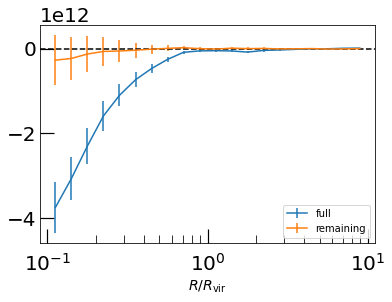

In [311]:
plt.errorbar(r_cent_lin_norm, cov_mean, yerr = cov_err, label = 'full')
plt.errorbar(r_cent_lin_norm, cov_remain, yerr = cov_err, label='remaining')
plt.axhline(0,linestyle='dashed', color='black')
plt.xscale('log'); #plt.yscale('log')
plt.xlabel(r'$R/R_{\rm vir}$', fontsize=14)
plt.legend()
plt.show()